In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import fftpack, integrate

**1.1**

In [3]:
def extrema_grid(N):
    n = np.arange(start=0, stop=N, step=1)
    return np.cos(np.pi * n/(N-1))

In [ ]:
def cheb(x):
    N = np.shape(x)[1]
    return 1/(N-1) * fftpack.dct(x, axis=1, type=1)

In [ ]:
def icheb(x):
    return  1/2 * fftpack.idct(x, axis=1, type=1)

In [ ]:
def test_inverse():
    N = 20
    vals = np.random.uniform(-1, 1, (1, N))
    forward = cheb(vals)
    backward = icheb(forward)
    np.testing.assert_allclose(vals, backward)

def test_delta():
  N = 2**5
  grid = extrema_grid(N)
  for m in range(N):
      input = np.zeros((1, N))
      input[0, m] = 1
      out = icheb(input)
      scale = 1
      if m == 0 or m == N-1:
          scale = 1/2
      desired = scale * np.cos(m * np.arccos(grid))
      np.testing.assert_allclose(out[0, :], desired)


def test_convergence():
    def f_test(x):
        return x**2 + np.tanh(x)

    def integrand(x, m):
        return 2/np.pi * f_test(x) * np.cos(m * np.arccos(x)) * 1/np.sqrt(1 - x**2)

    N = 2**10
    m_test = 7
    grid = np.expand_dims(extrema_grid(N), 0)
    f_sampled = f_test(grid)
    f_trns = cheb(f_sampled)
    exact = integrate.quad(lambda x: integrand(x, m_test), -1, 1)[0]
    fast = f_trns[0, m_test]
    np.testing.assert_allclose(exact, fast, rtol=1e-5)



In [ ]:
test_inverse()
test_delta()
test_convergence()

**2.2**

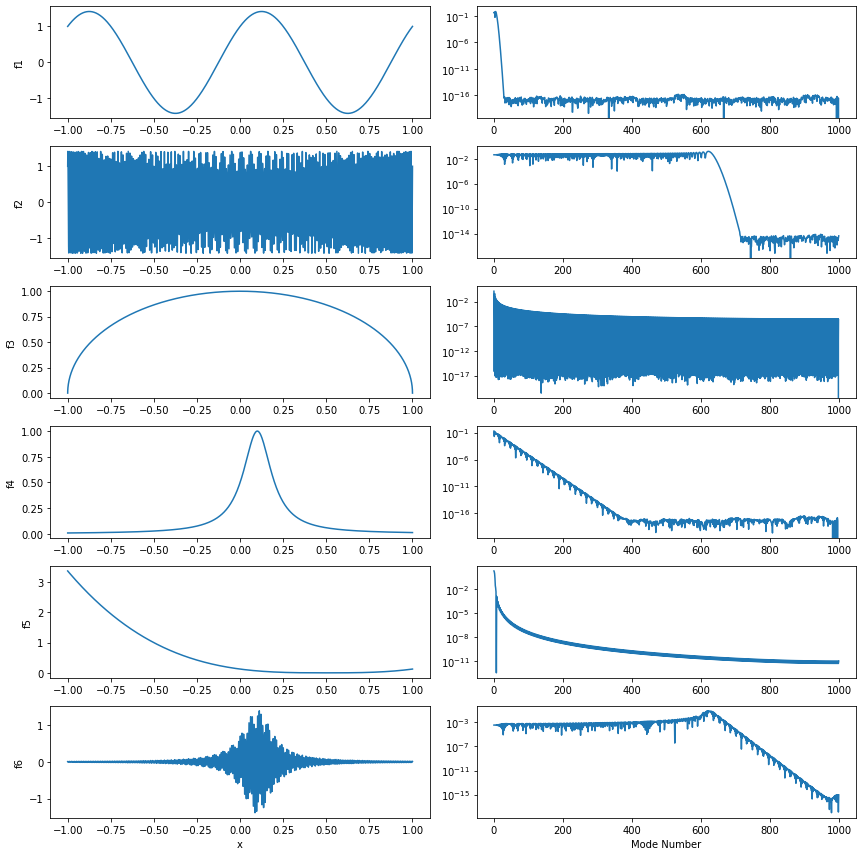

In [ ]:
N = 1000
grid = extrema_grid(N)
mode_nos = np.arange(start=0, stop=N, step=1)

f1 = np.cos(2 * np.pi * grid) + np.sin(2 * np.pi * grid)
f2 = np.cos(200 * np.pi * grid) + np.sin(200 * np.pi * grid)
f3 = np.sqrt(1 - grid**2)
f4 = 1/(1 + 100 * (grid - 1/10)**2)
f5 = np.abs(grid - 1/2)**3
f6 = f2 * f4

funcs = np.stack([f1, f2, f3, f4, f5, f6])
transforms = cheb(funcs)

fig, axs = plt.subplots(nrows=np.shape(funcs)[0], ncols=2, figsize=(12,12))
for i, (f, trns, ax) in enumerate(zip(funcs, transforms, axs)):
    ax[0].plot(grid, f)
    ax[0].set_ylabel("f{}".format(i+1))
    ax[1].plot(mode_nos, np.abs(trns), label="f{}".format(i))
    ax[1].set_yscale("log")
axs[-1, 1].set_xlabel("Mode Number")
axs[-1, 0].set_xlabel("x")
fig.tight_layout()
plt.show()

The behavior of $f_1$ is completely expected. The function is analytic and low frequency, so we see nearly immediate exponential decay in the series coeffecients.

$f_2$ also has exponentially decaying coeffecients, as it should given that it is analytic. The exponential decay starts at higher mode numbers, which is reasonable given that the function is has a much higher frequency than $f_1$.

In $f_3$ we see relatively slow convergence. This is probably because the function is not infinately differentiable at the endpoints, where the first deriviative is singular. Therefore, this behavior is expected.

$f_4$ converges exponentially starting at a relatively low mode number. This is expected, since it is analytic. So does $f_5$.

$f_6$ is interesting, because the mode structure looks like that of $f_4$ shifted up in frequency by the amount at which $f_2$ starts to converge. This is remenessant of the frequency shift property of the fourier transform. 

**2.1**

The model is,

$F[u] = x \frac{\partial^2 u}{\partial x^2} + 2 \frac{\partial u}{\partial x} + x u^n = 0$

The Frechet differential is,

$\lim_{\epsilon \to 0} \frac{\partial F[u_k + \epsilon v]}{∂ ϵ} = x \frac{\partial^2 v}{\partial x^2} + 2 \frac{\partial v}{\partial x} + n u_k^{n-1} v = F_u[u_k] v$

The first order expansion of the equation is then,

$F_u[u_k] v_{k+1} = -F[u_k]$

Such that,

$u_{k+1} = u_k + v_{k+1}$

Later I will want to map the domain of the equation from $[0, 1]$ to $[-1, 1]$. I can do this with the change of variables,

$y = 2 (x - \frac{1}{2})$

Such that,

$\frac{\partial v}{\partial x} = 2 \frac{\partial v}{\partial y}$ 

$\frac{\partial^2 v}{\partial x^2} = 4 \frac{\partial^2 v}{\partial y^2}$ 

**2.2/2.3**

In [4]:
def extrema_diff_mat(grid):
    N = len(grid)
    grid_idx = np.arange(start=0, stop=N, step=1)
    i_mat = np.tile(np.expand_dims(grid_idx, -1), [1, N])
    j_mat = np.tile(np.expand_dims(grid_idx, 0), [N, 1])
    x_i = np.tile(np.expand_dims(grid, -1), [1, N])
    x_j = np.tile(np.expand_dims(grid, 0), [N, 1])
    c_i = np.ones_like(i_mat)
    c_i[0, :] += 1
    c_i[-1, :] += 1
    c_j = np.transpose(c_i)
    d = (-1) ** (i_mat + j_mat) * c_i/(c_j * (x_i - x_j))
    diag = np.zeros_like(grid)
    diag[1:-1] = -grid[1:-1]/(2 * (1 - grid[1:-1]**2))
    diag[0] = (1 + 2 * (N-1)**2)/6
    diag[-1] = -(1 + 2 * (N-1)**2)/6
    np.fill_diagonal(d, diag)
    return d

In [5]:
def test_diff_mat_structure():
    N = 16
    grid = extrema_grid(N)
    dmat = extrema_diff_mat(grid)
    for i in range(N):
        for j in range(N):
            if i == 0 and j == 0:
                expected = (1 + 2 * (N-1)**2)/6
            elif i == N-1 and j == N-1:
                expected = -(1 + 2 * (N - 1) ** 2) / 6
            elif i == j:
                expected = -grid[i]/(2 * (1 - grid[i]**2))
            else:
                c_i = 1
                if i == 0:
                    c_i += 1
                elif i == N-1:
                    c_i += 1
                c_j = 1
                if j == 0:
                    c_j += 1
                elif j == N - 1:
                    c_j += 1
                expected = (-1)**(i+j) * (c_i)/(c_j * (grid[i] - grid[j]))
            actual = dmat[i, j]
            np.testing.assert_allclose(expected, actual)


def test_diff_mat():
    N = 32
    grid = extrema_grid(N)
    quad_coeff = np.random.uniform(1, 2)
    f = quad_coeff * (grid ** 2)
    deriv_mat = extrema_diff_mat(grid)
    deriv = deriv_mat.dot(f)
    second_deriv = deriv_mat.dot(deriv_mat).dot(f)
    expected = 2 * quad_coeff * grid
    np.testing.assert_allclose(deriv, expected)
    np.testing.assert_allclose(second_deriv, expected/grid)


In [6]:
test_diff_mat_structure()
test_diff_mat()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


In [7]:
def solve_update(grid, u_prev, n):
    grid_x = (grid + 1)/2
    diff_mat = extrema_diff_mat(grid)
    lhs_mat = 4 * np.diag(grid_x).dot(diff_mat).dot(diff_mat) + \
          4 * diff_mat + n * np.diag(grid_x * u_prev ** (n - 1))
    lhs_mat[0, :] = np.zeros_like(grid)
    lhs_mat[0, 0] = 1
    rhs = -1 * (2 * np.diag(grid + 1).dot(diff_mat).dot(diff_mat).dot(u_prev) + 4 * diff_mat.dot(u_prev) + (grid+1)/2 * u_prev**n)
    rhs[0] = 0
    return np.linalg.solve(lhs_mat, rhs)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


0.7255430374139362


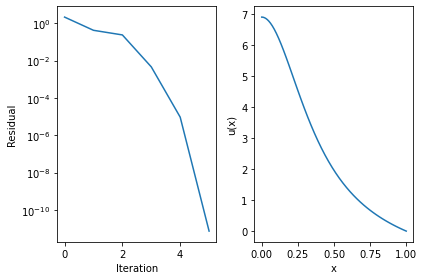

In [9]:
N = 64
n = 3

grid = extrema_grid(N)
grid_x = (grid + 1)/2
init_u = 5 * (1 - grid_x)

this_u = init_u
all_resids = []
for i in range(100000):
    this_v = solve_update(grid, this_u, n)
    resid = np.max(np.abs(this_v))
    all_resids.append(resid)
    this_u = this_u + this_v
    if resid < 1e-10:
        break


fig, axs = plt.subplots(ncols=2)
axs[0].plot(all_resids)
axs[0].set_yscale("log")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Residual")
axs[1].plot(grid_x, this_u)
axs[1].set_xlabel("x")
axs[1].set_ylabel("u(x)")

kg = 6.34e29
deriv_mat = extrema_diff_mat(grid)
soln_deriv = deriv_mat.dot(this_u)[0]
m = -1 * 4/np.sqrt(np.pi) * kg * soln_deriv
m_rel = m/1.99e30
print(m_rel)
fig.tight_layout()

It seems like the residual is being squared every iteration, which is what we should expect based on the lecture notes.

As found above, $M/M_{\odot} \approxeq 0.7$.